# IBM Optimizations using Cirq

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/optimizations/ibm/ibmq_compile_css.ipynb) [![Launch Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/optimizations/ibm/ibmq_compile_css.ipynb)

Below is a brief tutorial on Superstaq optimizations for IBM Quantum superconducting qubit devices. For more information on IBM Quantum, visit their website [here](https://www.ibm.com/quantum).

## Imports and API Token

This example tutorial notebook uses `cirq-superstaq`, our Superstaq client for Cirq; you can try it out by running `pip install cirq-superstaq[examples]`:

In [1]:
try:
    import cirq
    import cirq_superstaq as css
    import qiskit
except ImportError:
    print("Installing cirq-superstaq...")
    %pip install --quiet 'cirq-superstaq[examples]'
    print("Installed cirq-superstaq.")
    print("You may need to restart the kernel to import newly installed packages.")
    import cirq
    import cirq_superstaq as css
    import qiskit

import numpy as np

To interface Superstaq via Cirq, we must first instantiate a service with `cirq_superstaq.Service()`. We then supply a Superstaq API token by either providing the API token as an argument to `cirq_superstaq.Service()` or by setting it as an environment variable (see more details [here](https://superstaq.readthedocs.io/en/latest/get_started/basics/basics_css.html#Set-up-access-to-Superstaq%E2%80%99s-API))

In [2]:
# Provide your Superstaq API key using the "api_key" argument
service = css.Service()

## Single Circuit Compilation

Let us start by creating an example Cirq circuit that we will then compile and optimize for the 127-qubit IBM Quantum `brisbane` processor.

In [3]:
# Create a two-qubit cirq circuit
qubits = cirq.LineQubit.range(2)
theta = np.random.uniform(0, 4 * np.pi)
circuit = cirq.Circuit(
    cirq.CNOT(qubits[0], qubits[1]),
    cirq.Rz(rads=theta)(qubits[1]),
    cirq.CNOT(qubits[0], qubits[1]),
    css.barrier(*qubits),
    cirq.measure(qubits[0], qubits[1]),
)

# Visualize circuit
circuit

0: ───@────────────────@───│───M───
      │                │   │   │
1: ───X───Rz(0.413π)───X───│───M───

We will now compile the above circuit to IBM's `brisbane` processor and visualize the differences by drawing the compiled circuit. 

In [4]:
# Compile with qscout compile
compiler_output = service.ibmq_compile(circuit, target="ibmq_brisbane_qpu")

# Call circuit from the compiler output to get the corresponding output circuit
output_circuit = compiler_output.circuit

# Visualize the compiled circuit
output_circuit

4: ───Rz(0.5π)───X───────────────AceCR+-(Z side)───Rz(0.5π)────X───────AceCR+-(Z side)───────│───M('q(0),q(1)')───
                                 │                                     │                     │   │
5: ───Rz(π)──────X^0.5───Rz(π)───AceCR+-(X side)───Rz(1.59π)───X^0.5───AceCR+-(X side)───X───│───M────────────────

The resulting output is now a circuit compiled to `brisbane`'s native operations. With Superstaq compilation, you can also observe the gates and gate times for the compiled circuit using Qiskit’s timeline drawer (see [Qiskit Timeline Visualizations Documentation](https://docs.quantum.ibm.com/api/qiskit/qiskit.visualization.timeline_drawer)) by running the following:

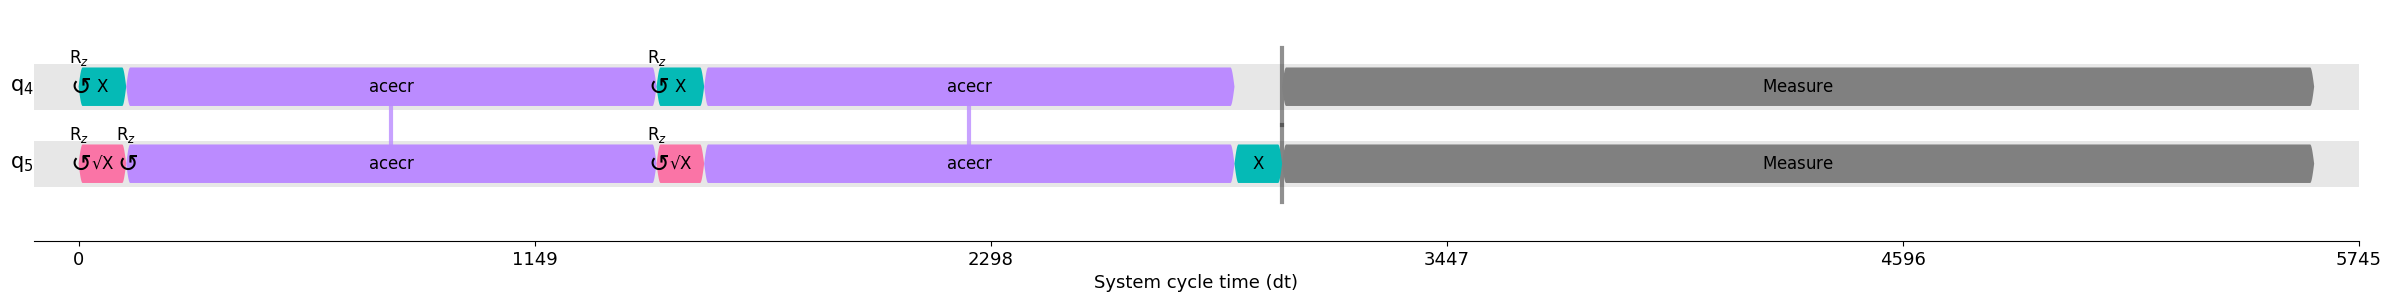

In [5]:
# The pulse gate circuit is obtained via the `pulse_gate_circuit` attribute
pulse_circuit = compiler_output.pulse_gate_circuit

custom_style = {"formatter.general.fig_width": 30, "formatter.general.fig_unit_height": 1}
style = qiskit.visualization.timeline.IQXStandard(**custom_style)

qiskit.visualization.timeline_drawer(pulse_circuit, idle_wires=False, style=style)

## Multiple Circuits Compilation

All the functionalities we have seen so far can also be used on a multiple-circuit input as well. To illustrate this, let us create a different example two-qubit circuit: a Bell-state circuit.

In [6]:
# Create second circuit
bell_circuit = cirq.Circuit(
    cirq.H(qubits[0]), cirq.CNOT(qubits[0], qubits[1]), cirq.measure(qubits[0], qubits[1])
)

# Visualize second circuit
bell_circuit

0: ───H───@───M───
          │   │
1: ───────X───M───

By passing multiple circuits as a list to the `ibmq_compile` endpoint, we can compile all of them individually with a single call to the endpoint. This will return all the corresponding compiled circuits and pulse gate circuits back as a list, like so:  

In [7]:
# Create list of circuits
circuit_list = [circuit, bell_circuit]

# Compile list of circuits
compiler_output_list = service.ibmq_compile(circuit_list, "ibmq_brisbane_qpu")

# The list of compiled output circuits is stored in the `circuits` attribute instead of `circuit`. Likewise for
# pulse gate circuits.
output_circuits = compiler_output_list.circuits
pulse_gate_circuits = compiler_output_list.pulse_gate_circuits

In [8]:
# Visualize the first compiled circuit
print("Compiled circuit 1 \n")
output_circuits[0]

Compiled circuit 1 



4: ───Rz(1.5π)───X^0.5───Rz(π)──────AceCR+-(Z side)───Rz(0.5π)───X^0.5───Rz(1.59π)───X^0.5───AceCR+-(Z side)───Rz(1.5π)───X^0.5───Rz(0.5π)───│───M────────────────
                                    │                                                        │                                               │   │
5: ───Rz(π)──────X^0.5───Rz(0.5π)───AceCR+-(X side)──────────────X^0.5───────────────────────AceCR+-(X side)───Rz(0.5π)───X^0.5───Rz(0.5π)───│───M('q(0),q(1)')───

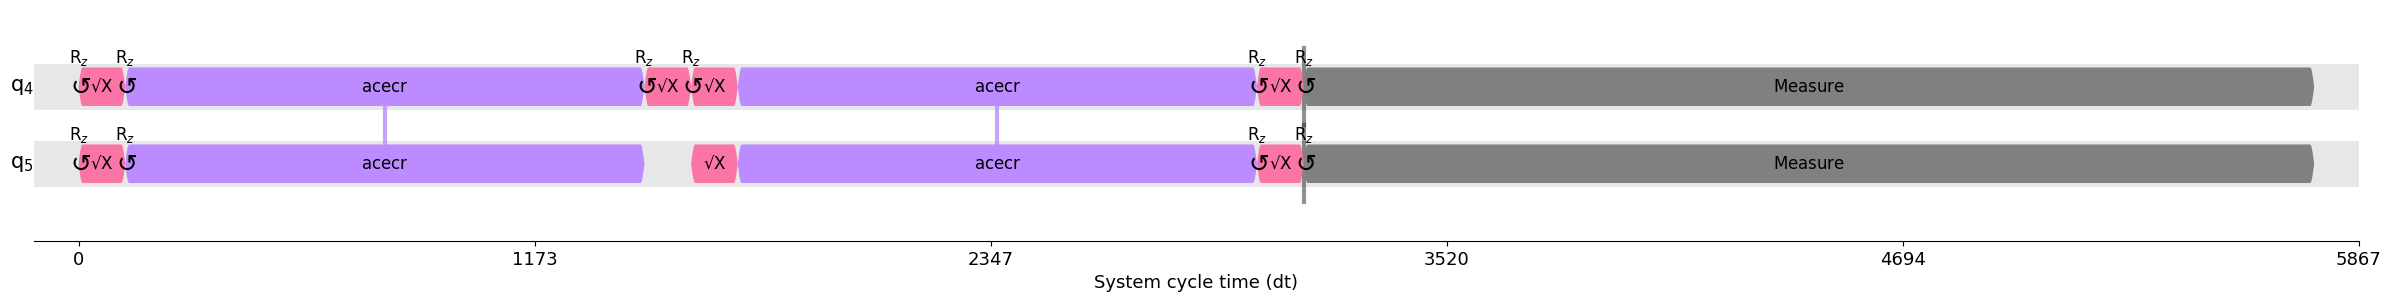

In [9]:
# Visualize the pulse gate circuit for the first compiled circuit
qiskit.visualization.timeline_drawer(pulse_gate_circuits[0], idle_wires=False, style=style)

In [10]:
# Visualize the second compiled circuit
print("Compiled circuit 2 \n")
output_circuits[1]

Compiled circuit 2 



4: ───Rz(0.5π)───X^0.5───AceCR+-(Z side)───Rz(0.5π)───X^0.5───│───M────────────────
                         │                                    │   │
5: ──────────────────────AceCR+-(X side)───Rz(0.5π)───X^0.5───│───M('q(0),q(1)')───

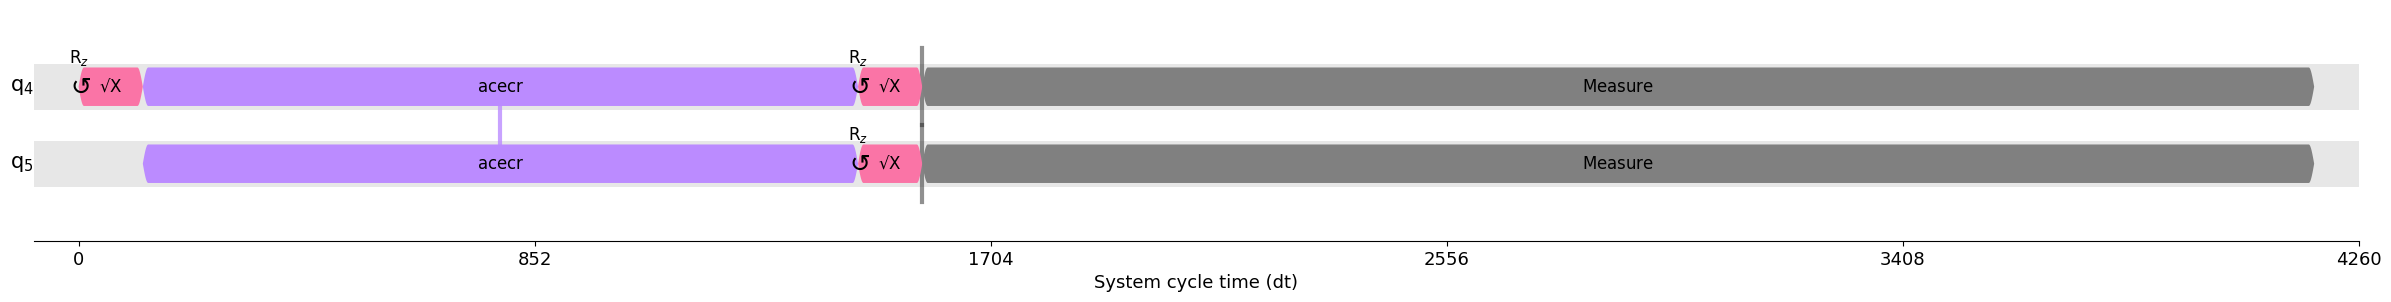

In [11]:
# Visualize the pulse gate circuit for the second compiled circuit
qiskit.visualization.timeline_drawer(pulse_gate_circuits[1], idle_wires=False, style=style)

## Using the Superstaq Simulator

Lastly, we will show (a) how to submit a circuit to a backend and (b) how to simulate circuit execution. Simulation is available to free trial users, and can be done by passing the `"dry-run"` method parameter when calling `create_job()` on the Superstaq service.

In [12]:
# Create job that submits to IBM Quantum backend
job = service.create_job(
    bell_circuit,
    repetitions=1000,
    target="ibmq_brisbane_qpu",
    method="dry-run",  # Specify "dry-run" as the method to run Superstaq simulation
)

# Get the counts from the measurement
print(job.counts(0))

{'11': 504, '00': 496}
